# 1. Some pre-installation and pre-loading

In [ ]:
# %%capture
# import torch
# major_version, minor_version = torch.cuda.get_device_capability()
# # Must install separately since Colab has torch 2.2.1, which breaks packages
# !pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# if major_version >= 8:
#     # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
#     !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
# else:
#     # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
#     !pip install --no-deps xformers trl peft accelerate bitsandbytes
# pass

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/Shareddrives/CS685Project/Project/

Mounted at /content/drive
/content/drive/Shareddrives/CS685Project/Project


In [6]:
import torch

hyper_params = {
    # Model hyperparameters
    "max_seq_length": 4096, # 8192 | Choose any! We auto support RoPE Scaling internally!
    "dtype": None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    "load_in_4bit": True, # Use 4bit quantization to reduce memory usage. Can be False.,
    "model_name": "unsloth/gemma-2b-it-bnb-4bit",
    "r": 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Add more to target more modules
    "lora_alpha": 16,
    "lora_dropout": 0, # Supports any, but = 0 is optimized
    "lora_bias": "none", # Supports any, but = "none" is optimized
    "lora_use_gradient_checkpointing": "unsloth", # True or "unsloth" for very long context
    "lora_random_state": 3407,
    "lora_use_rslora": False, # We support rank stabilized LoRA
    "lora_loftq_config": None, # And LoftQ
    # Training hyperparameters
    "dataset_train_path": "./data/gemma_chat_train",
    "dataset_eval_path": "./data/gemma_chat_eval",
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 1,
    "warmup_steps": 15, # will replace num_warmup_steps in lr_scheduler_kwargs
    # "num_train_epochs": 1, # choose between num_train_epochs and max_steps
    "max_steps": 60, # choose between num_train_epochs and max_steps
    "learning_rate": 1e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "cosine_with_restarts",
    "lr_scheduler_kwargs": {"num_cycles": 2}, # "num_warmup_steps" and "num_training_steps" will be added automatically
    "seed": 3407,
}

In [7]:
from unsloth import FastLanguageModel

max_seq_length = hyper_params["max_seq_length"] # 8192 | Choose any! We auto support RoPE Scaling internally!
dtype = hyper_params["dtype"] # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = hyper_params["load_in_4bit"] # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = hyper_params["model_name"],
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


In [8]:
# add lora to model
model = FastLanguageModel.get_peft_model(
    model,
    r = hyper_params["r"], # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128,
    target_modules = hyper_params["target_modules"], # Add more to target more modules
    lora_alpha = hyper_params["lora_alpha"],
    lora_dropout = hyper_params["lora_dropout"], # Supports any, but = 0 is optimized
    bias = hyper_params["lora_bias"], # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = hyper_params["lora_use_gradient_checkpointing"], # True or "unsloth" for very long context
    random_state = hyper_params["lora_random_state"],
    use_rslora = hyper_params["lora_use_rslora"], # We support rank stabilized LoRA
    loftq_config = hyper_params["lora_loftq_config"], # And LoftQ
)

Unsloth 2024.4 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


# 2. Dataset Preparation

In [3]:
import json

# read the training data from json
with open('./data/training_data.json', 'r') as file:
    training_data = json.load(file)

# asins_small.json to be used for meta data matching
json_file_asins = './data/asins_small.json'
with open(json_file_asins, "r") as file:
    asin_dict = json.load(file)

In [4]:
training_data['14']

{'full_intention_prompt': "I have watched these following movies and have given reviews respectively: \n ```Watched Movie:\ntitle: One Step Behind \ndescription: A dangerous man awakes in the care of a mysterious woman. Once the pieces of his past fall into place, he's faced with the stark choice of accepting his new found love or becoming the man he once was. \nUser rating: 4.0 \nUser Review: Nice Hard Boiled Indie! Plenty of Bad Guys, Femme Fatales and one Big Bad Ass Reluctant Hero! If you like old school Film Noir -  more specifically Hard Boiled - you'll enjoy this little indie film. It reminded me a lot of the Coen Brother's BLOOD SIMPLE and another desert noir from the 90s starring Nick Cage RED ROCK WEST. It has that same pace and flavor to it and it pays of at the end. Well done! \n-------\nWatched Movie:\ntitle: Untouched \ndescription: This legal drama explores the life-changing effects a secret abortion has on Mitch Thomas. A town startled by an infant found murdered in a d

In [6]:
# gemma chat template test
chat = [
    { "role": "user", "content": "input_test" },
    # { "role": "assistant", "content": "output_test" },    
]
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False)
prompt

'<bos><start_of_turn>user\ninput_test<end_of_turn>\n'

In [9]:
from transformers import AutoTokenizer

# prompt_template = "### Input:\n{}\n\n### Response:{}"
# gemma chat template:
prompt_template = "<bos><start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}<end_of_turn>\n"

def token_length(text, tokenzier):
    input_ids = tokenizer(text, return_tensors="pt").to("cuda")
    return len(input_ids[0])

prompt_template_token_length = token_length(prompt_template, tokenizer)
print("prompt_template_token_length: ", prompt_template_token_length)

prompt_template_token_length:  11


### 2.1 no intention dataset

In [10]:
# construct training data with no intention in the prompt, just user history
from tqdm import tqdm

training_dict_no_user_intention_wo_description = {"input": [], "output": []}
training_dict_no_user_intention_w_description = {"input": [], "output": []}

for key in tqdm(training_data, total=len(training_data)):
    # print("synthesized intention: ", training_data[key]["intention"])
    # print("movie_sequence: ", training_data[key]["history"])
    # synthesized_intention = training_data[key]["intention"]
    item_sequence = training_data[key]["history"]

    # beginning of the instruction:
    beginning_instruction = f"Below is the previous historical purchases and reviews of the user:\n```\n"

    # construct movie sequence text
    item_seq_text = ''
    for item in item_sequence[:-1]:
        title = asin_dict[item[5]][0]
        description = asin_dict[item[5]][1]
        
        rating = item[0]
        review = item[2]

        template = f"Item title: {title} \n Item description: {' '.join(description)} \n rating: {rating} \n review: {review}-------\n"
        item_seq_text += template

    # # user's intention:
    # user_intention_instruction = f"```\nAnd here is the user's intention: {synthesized_intention}\n"

    # ending of the instruction:
    ending_instruction_wo_description = f"Please infer the user's preference based on historical purchases and reviews, and then recommend an item for this user. Please just give the title of the recommended item."
    ending_instruction_w_description = f"Please infer the user's preference based on historical purchases and reviews, and then recommend an item for this user. Please provide the recommended item's title and description."

    # get the ground truth item
    ground_truth_title = asin_dict[item_sequence[-1][5]][0]
    ground_truth_description = ' '.join(asin_dict[item_sequence[-1][5]][1])
    
    if ground_truth_title is None or ground_truth_title.strip() == "" or ground_truth_description is None or ground_truth_description.strip() == "":
        continue
    
    output_wo_description = asin_dict[item_sequence[-1][5]][0] # targeted item's title
    output_w_description = f"Title: {ground_truth_title} \n Description: {ground_truth_description}"

    input_wo_description = beginning_instruction + item_seq_text + ending_instruction_wo_description
    input_w_description = beginning_instruction + item_seq_text + ending_instruction_w_description
        
    # appending to the list in training_dict with filtering on length
    if token_length(input_wo_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_no_user_intention_wo_description["input"].append(input_wo_description)
        training_dict_no_user_intention_wo_description["output"].append(output_wo_description)

    if token_length(input_w_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_no_user_intention_w_description["input"].append(input_w_description)
        training_dict_no_user_intention_w_description["output"].append(output_w_description)
        
    # WARNING: repeated data tokens. 
    # Potential solution: randomly choose from w w/o description.

# save to ./data
with open('./data/gemma_chat_training_no_user_intention_wo_description_fixed_empty_string_filter.json', 'w') as file:
    json.dump(training_dict_no_user_intention_wo_description, file, indent=4)
with open('./data/gemma_chat_training_no_user_intention_w_description_fixed_empty_string_filter.json', 'w') as file:
    json.dump(training_dict_no_user_intention_w_description, file, indent=4)

100%|██████████| 8241/8241 [01:04<00:00, 126.90it/s]


In [11]:
with open('./data/gemma_chat_training_no_user_intention_wo_description_fixed_empty_string_filter.json', 'r') as file:
    gemma_train_no_user_intention_wo_description = json.load(file)
with open('./data/gemma_chat_training_no_user_intention_w_description_fixed_empty_string_filter.json', 'r') as file:
    gemma_train_no_user_intention_w_description = json.load(file)

In [17]:
len(gemma_train_no_user_intention_wo_description["input"]), \
len(gemma_train_no_user_intention_w_description["input"])

(7315, 7314)

In [18]:
# construct dataset
from datasets import Dataset

gemma_train_no_user_intention_two_tasks = {"input": [], "output": []}

for i in range(len(gemma_train_no_user_intention_wo_description["input"])):
    gemma_train_no_user_intention_two_tasks["input"].append(gemma_train_no_user_intention_wo_description["input"][i])
    gemma_train_no_user_intention_two_tasks["output"].append(gemma_train_no_user_intention_wo_description["output"][i])

for i in range(len(gemma_train_no_user_intention_w_description["input"])):
    gemma_train_no_user_intention_two_tasks["input"].append(gemma_train_no_user_intention_w_description["input"][i])
    gemma_train_no_user_intention_two_tasks["output"].append(gemma_train_no_user_intention_w_description["output"][i])

dataset_two_tasks = Dataset.from_dict(gemma_train_no_user_intention_two_tasks)

dataset_two_tasks = dataset_two_tasks.train_test_split(test_size=0.007)
dataset_train, dataset_eval = dataset_two_tasks["train"], dataset_two_tasks["test"]

# dataset_eval = dataset_eval.train_test_split(test_size=0.5)
# dataset_eval, dataset_test = dataset_eval["train"], dataset_eval["test"]

In [19]:
dataset_train, dataset_eval

(Dataset({
     features: ['input', 'output'],
     num_rows: 14526
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 103
 }))

In [20]:
# save huggingface dataset to local
# gemma_chat_train with shuffled data
# gemma_chat_train_fixed without shuffling
dataset_train.save_to_disk('./data/gemma_chat_train_no_user_intention_fixed_empty_string_filter')
dataset_eval.save_to_disk('./data/gemma_chat_eval_no_user_intention_fixed_empty_string_filter')

Saving the dataset (0/1 shards):   0%|          | 0/14526 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/103 [00:00<?, ? examples/s]

### 2.2 With user intention dataset

In [18]:
from tqdm import tqdm

training_dict_wo_description = {"input": [], "output": []}
training_dict_w_description = {"input": [], "output": []}

for key in tqdm(training_data, total=len(training_data)):
    # print("synthesized intention: ", training_data[key]["intention"])
    # print("movie_sequence: ", training_data[key]["history"])
    synthesized_intention = training_data[key]["intention"]
    item_sequence = training_data[key]["history"]

    # beginning of the instruction:
    beginning_instruction = f"Below is the previous historical purchases and reviews of the user:\n```\n"

    # construct movie sequence text
    item_seq_text = ''
    for item in item_sequence[:-1]:
        title = asin_dict[item[5]][0]
        description = asin_dict[item[5]][1]
        
        rating = item[0]
        review = item[2]

        template = f"Item title: {title} \n Item description: {' '.join(description)} \n rating: {rating} \n review: {review}-------\n"
        item_seq_text += template

    # user's intention:
    user_intention_instruction = f"```\nAnd here is the user's intention: {synthesized_intention}\n"

    # ending of the instruction:
    ending_instruction_wo_description = f"Please infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user. Please just give the title of the recommended item."
    ending_instruction_w_description = f"Please infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user. Please provide the recommended item's title and description."

    # get the ground truth item
    ground_truth_title = asin_dict[item_sequence[-1][5]][0]
    ground_truth_description = ' '.join(asin_dict[item_sequence[-1][5]][1])
    
    if ground_truth_title is None or ground_truth_title.strip() == "" or ground_truth_description is None or ground_truth_description.strip() == "":
        continue
    
    output_wo_description = asin_dict[item_sequence[-1][5]][0] # targeted item's title
    output_w_description = f"Title: {ground_truth_title} \n Description: {ground_truth_description}"

    input_wo_description = beginning_instruction + item_seq_text + user_intention_instruction + ending_instruction_wo_description
    input_w_description = beginning_instruction + item_seq_text + user_intention_instruction + ending_instruction_w_description
        
    # appending to the list in training_dict with filtering on length
    if token_length(input_wo_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_wo_description["input"].append(input_wo_description)
        training_dict_wo_description["output"].append(output_wo_description)

    if token_length(input_w_description, tokenizer) <= max_seq_length - prompt_template_token_length:
        training_dict_w_description["input"].append(input_w_description)
        training_dict_w_description["output"].append(output_w_description)

    # WARNING: repeated data tokens. 
    # Potential solution: randomly choose from w w/o description.

# save to ./data
with open('./data/gemma_chat_training_wo_description_fixed_empty_string_filter.json', 'w') as file:
    json.dump(training_dict_wo_description, file, indent=4)
with open('./data/gemma_chat_training_w_description_fixed_empty_string_filter.json', 'w') as file:
    json.dump(training_dict_w_description, file, indent=4)

100%|██████████| 8241/8241 [01:33<00:00, 88.48it/s] 


In [4]:
import json
# read data
# with open('./data/gemma_chat_training_wo_description_fixed.json', 'r') as file:
#     gemma_train_wo_description = json.load(file)
# with open('./data/gemma_chat_training_w_description_fixed.json', 'r') as file:
#     gemma_train_w_description = json.load(file)
    
with open('./data/gemma_chat_training_wo_description_fixed_empty_string_filter.json', 'r') as file:
    gemma_train_wo_description = json.load(file)
with open('./data/gemma_chat_training_w_description_fixed_empty_string_filter.json', 'r') as file:
    gemma_train_w_description = json.load(file)

In [5]:
len(gemma_train_wo_description["input"]), \
len(gemma_train_w_description["input"])
# 7813 for gemma_chat_training_wo_description_fixed

(7305, 7305)

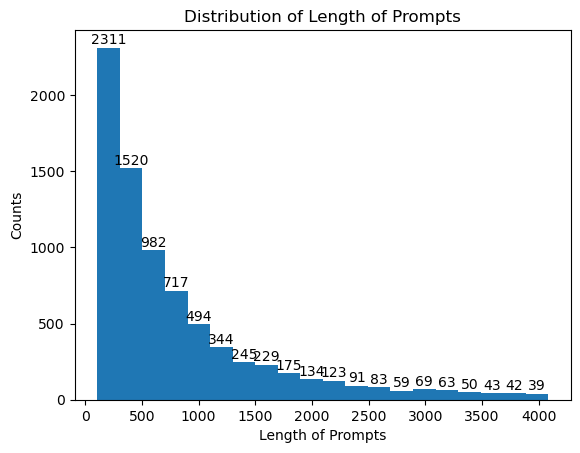

In [45]:
# Distribution of Length of Prompts in training dict
import matplotlib.pyplot as plt

# Assume 'length_of_prompts' is a list of prompt lengths that you've calculated earlier
length_of_prompts = [token_length(x, tokenizer) for x in gemma_train_wo_description["input"]]
# length_of_prompts = [token_length(x, tokenizer) for x in gemma_train_w_description["input"]]

# Create the histogram and get the number of occurrences and the bin edges
counts, bins, patches = plt.hist(length_of_prompts, bins=20)

# Loop over the patches (bars) and add a text label above each bar
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 5, str(int(count)),
             ha='center', va='bottom')

plt.xlabel('Length of Prompts')
plt.ylabel('Counts')
plt.title('Distribution of Length of Prompts')
plt.show()

In [8]:
# construct dataset
from datasets import Dataset

# gemma_train_two_tasks = {key: gemma_train_wo_description[key] + gemma_train_w_description[key] for key in gemma_train_wo_description}
# iterate through the two tasks, i to index the two tasks
# make the merged dataset, one from each task, pair by pair
# gemma_train_two_tasks = {"input": [], "output": []}

# make seperate dataset for each task
gemma_train_wo_desc_task = {"input": [], "output": []}
gemma_train_w_desc_task = {"input": [], "output": []}

# for i in range(len(gemma_train_wo_description["input"])):
    # gemma_train_two_tasks["input"].append(gemma_train_wo_description["input"][i])
    # gemma_train_two_tasks["output"].append(gemma_train_wo_description["output"][i])

    # gemma_train_two_tasks["input"].append(gemma_train_w_description["input"][i])
    # gemma_train_two_tasks["output"].append(gemma_train_w_description["output"][i])

for i in range(len(gemma_train_wo_description["input"])):
    gemma_train_wo_desc_task["input"].append(gemma_train_wo_description["input"][i])
    gemma_train_wo_desc_task["output"].append(gemma_train_wo_description["output"][i])

for i in range(len(gemma_train_w_description["input"])):
    gemma_train_w_desc_task["input"].append(gemma_train_w_description["input"][i])
    gemma_train_w_desc_task["output"].append(gemma_train_w_description["output"][i])
    

# dataset_two_tasks = Dataset.from_dict(gemma_train_two_tasks)

# dataset_two_tasks = dataset_two_tasks.train_test_split(test_size=0.007)
# dataset_train, dataset_eval = dataset_two_tasks["train"], dataset_two_tasks["test"]

dataset_wo_desc_task = Dataset.from_dict(gemma_train_wo_desc_task)

dataset_wo_desc_task = dataset_wo_desc_task.train_test_split(test_size=0.007)
dataset_wo_desc_task_train, dataset_wo_desc_task_eval = dataset_wo_desc_task["train"], dataset_wo_desc_task["test"]

dataset_w_desc_task = Dataset.from_dict(gemma_train_w_desc_task)
dataset_w_desc_task = dataset_w_desc_task.train_test_split(test_size=0.007)
dataset_w_desc_task_train, dataset_w_desc_task_eval = dataset_w_desc_task["train"], dataset_w_desc_task["test"]

# dataset_eval = dataset_eval.train_test_split(test_size=0.5)
# dataset_eval, dataset_test = dataset_eval["train"], dataset_eval["test"]

In [9]:
# dataset_train, dataset_eval
dataset_wo_desc_task_train, dataset_wo_desc_task_eval,\
dataset_w_desc_task_train, dataset_w_desc_task_eval

(Dataset({
     features: ['input', 'output'],
     num_rows: 7253
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 52
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 7253
 }),
 Dataset({
     features: ['input', 'output'],
     num_rows: 52
 }))

In [10]:
# save huggingface dataset to local
# gemma_chat_train with shuffled data
# gemma_chat_train_fixed without shuffling
# dataset_train.save_to_disk('./data/gemma_chat_train_fixed_empty_string_filter')
# dataset_eval.save_to_disk('./data/gemma_chat_eval_fixed_empty_string_filter')
dataset_wo_desc_task_train.save_to_disk('./data/gemma_chat_train_wo_desc_task_fixed_empty_string_filter')
dataset_wo_desc_task_eval.save_to_disk('./data/gemma_chat_eval_wo_desc_task_fixed_empty_string_filter')
dataset_w_desc_task_train.save_to_disk('./data/gemma_chat_train_w_desc_task_fixed_empty_string_filter')
dataset_w_desc_task_eval.save_to_disk('./data/gemma_chat_eval_w_desc_task_fixed_empty_string_filter')

Saving the dataset (0/1 shards):   0%|          | 0/7253 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/52 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7253 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/52 [00:00<?, ? examples/s]

In [29]:
# count = 0
# for i in range(len(dataset_two_tasks['test'])):
#   if dataset_two_tasks['test'][i]['output'].startswith("Title:"):
#     count += 1
# print(count)
# print(count / len(dataset_two_tasks['test']))

60
0.5454545454545454


### 2.3 Training data of title_desc_category task

# 3. Training

In [5]:
# read huggingface dataset from local
from datasets import load_from_disk

dataset_train = load_from_disk(hyper_params["dataset_train_path"])
# dataset_eval = load_from_disk('./data/gemma_chat_eval_fixed')

In [6]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}<end_of_turn>\n"

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []

    for input, output in zip(inputs, outputs):
        # text = "### Input:\n{inputs_holder}\n\n### Response:{outputs_holder}".format(inputs_holder= input, outputs_holder= output) + EOS_TOKEN
        # gemma chat template:
        text = prompt_template.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

train_dataset = dataset_train.map(formatting_prompts_func, batched = True,)
# test_dataset = dataset_eval.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/15516 [00:00<?, ? examples/s]

In [7]:
train_dataset[0]

{'input': 'Below is the previous historical purchases and reviews of the user:\n```\nItem title: The Frozen Ground [DVD+Digital] \n Item description: Frozen Ground Is Inspired By the Incredible True Story That Follows Alaskan State Trooper Jack Halcombe (Nicolas Cage) As He Sets Out to End the Murderous Rampage of Robert Hansen (John Cusack), a Serial Killer Who Has Gone Unnoticed for 13 Years. As the Bodies of Street Girls Start to Pile Up in Anchorage, Fear Strikes a Chord with the Public. Risking His Life, Halcombe Goes on a Personal Manhunt to Find the Killer Before the Next Body Surfaces. When a Seventeen Year Old Escapee (Vanessa Hudgens) Reveals Key Information About the Case, Halcombe Is Finally on the Trail of the Killer. But Will He Catch Him in Time to Save the Next Victim? \n rating: 5.0 \n review: Great movie-------\nItem title: Seeking Justice \n Item description: This action-packed thriller stars Nicolas Cage as Will Gerard, a happily married family man whose quiet life 

In [ ]:
# # test of calculating num_training_steps
# hyper_params = {
#     "per_device_train_batch_size": 1,
#     "num_train_epochs": 1,
#     "gradient_accumulation_steps": 1,
#     "lr_scheduler_kwargs": {
#         "num_warmup_steps": 100,
#     },
# }
# hyper_params["lr_scheduler_kwargs"]["num_training_steps"] = len(train_dataset) * hyper_params["num_train_epochs"] // (hyper_params["per_device_train_batch_size"] * hyper_params["gradient_accumulation_steps"])
# hyper_params

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = test_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = hyper_params["per_device_train_batch_size"],
        gradient_accumulation_steps = hyper_params["gradient_accumulation_steps"],
        warmup_steps = hyper_params["warmup_steps"],
        # num_train_epochs = 1,
        max_steps = hyper_params["max_steps"],
        learning_rate = hyper_params["learning_rate"],
        fp16 = hyper_params["fp16"],
        bf16 = hyper_params["bf16"],
        logging_steps = hyper_params["logging_steps"],
        optim = hyper_params["optim"],
        weight_decay = hyper_params["weight_decay"],
        lr_scheduler_type = hyper_params["lr_scheduler_type"],
        lr_scheduler_kwargs = hyper_params['lr_scheduler_kwargs'],
        seed = hyper_params["seed"],
        output_dir = "outputs",
        # fp16_full_eval = True,
        # per_device_eval_batch_size = 1,
        # eval_accumulation_steps = 1,
        # evaluation_strategy = "steps",
        # eval_steps = 10,
    ),
)

Map (num_proc=2):   0%|          | 0/15516 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.581 GB.
2.314 GB of memory reserved.


In [12]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 15,516 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 1
\        /    Total batch size = 2 | Total steps = 60
 "-____-"     Number of trainable parameters = 9,805,824


Step,Training Loss
1,3.482300
2,4.031300
3,3.891500
4,4.350400
5,4.040200
6,3.632900
7,4.202200
8,3.890300
9,3.409200
10,3.817300


In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

148.9093 seconds used for training.
2.48 minutes used for training.
Peak reserved memory = 13.797 GB.
Peak reserved memory for training = 11.483 GB.
Peak reserved memory % of max memory = 94.623 %.
Peak reserved memory for training % of max memory = 78.753 %.


# 4. Saving, loading and inference with finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [14]:
import json
from datetime import datetime

# get current datetime
now = datetime.now()

# name the model
model_name = "model_" + now.strftime("%m%d%Y_%H%M%S")
model_path = "outputs/" + model_name
model.save_pretrained(model_path) # Local saving

# save hyperparameters as a json dict to model_path
with open(model_path + "/hyperparameters.json", "w") as file:
    json.dump(hyper_params, file, indent=4)
    
# save trainer.state.log_history to model_path
with open(model_path + "/trainer_state_log_history.json", "w") as file:
    json.dump(trainer.state.log_history, file, indent=4)

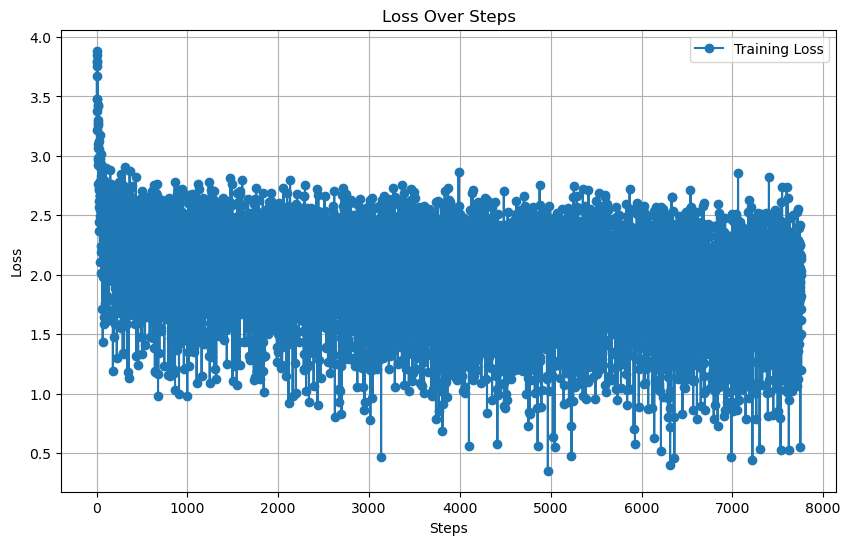

In [4]:
import json
import matplotlib.pyplot as plt

# read trainer.state.log_history from path
with open("./outputs/model_04242024_090830/trainer_state_log_history.json", "r") as file:
    trainer_log_history = json.load(file)

# plot trainer.state.log_history, plot training loss and evaluation loss
# Extracting training and eval loss data
train_losses = []
eval_losses = []
steps = []

for entry in trainer_log_history:
    if 'loss' in entry:
        train_losses.append((entry['step'], entry['loss']))
    if 'eval_loss' in entry:
        eval_losses.append((entry['step'], entry['eval_loss']))
    if 'train_loss' in entry:
        train_losses.append((entry['step'], entry['train_loss']))

# Sorting values by steps to align the data points correctly
train_losses.sort(key=lambda x: x[0])
eval_losses.sort(key=lambda x: x[0])

# Plotting
plt.figure(figsize=(10, 6))
# Unzipping for plotting
if eval_losses != []:
    train_steps, train_loss_values = zip(*train_losses)
    eval_steps, eval_loss_values = zip(*eval_losses)
    plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')
    plt.plot(eval_steps, eval_loss_values, label='Evaluation Loss', marker='x')
else:
    train_steps, train_loss_values = zip(*train_losses)
    plt.plot(train_steps, train_loss_values, label='Training Loss', marker='o')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# read eval dataset from local
from datasets import load_from_disk

dataset_eval = load_from_disk(hyper_params["dataset_eval_path"])
print("Loaded eval dataset from {}".format(hyper_params["dataset_eval_path"]))

Loaded eval dataset from ./data/gemma_chat_eval


In [5]:
index_i = 6
dataset_eval[index_i]['input'], \
dataset_eval[index_i]['output']

('Below is the previous historical purchases and reviews of the user:\n```\nItem title: Ice Age: The Meltdown \n Item description: Product Description Your favorite sub-zero heroes are back for another incredible adventure in the super-cool animated comedy Ice Age the Meltdown! The action heats up Amazon.com The love life of a woolly mammoth--handled with G-rated delicacy--drives this sequel to the first computer-animated romp in the age of prehistoric mammals. While the first Ice Age took a delightful premise and suffocated it with a formulaic plot--in which a mammoth named Manfred (voiced by Ray Romano, Everyone Loves Raymond ), a sloth named Sid (John Leguizamo, Moulin Rouge! ), and a sabre-tooth tiger named Diego (Denis Leary, Rescue Me ) helped an abandoned human infant return to its tribe (basically, Three Mammals and a Baby )--the sequel takes the now-familiar setting, gives it a shapeless, episodic storyline, and yet somehow becomes pretty darn entertaining. Faced with the thre

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [6]:
if True:
    max_seq_length = 4096 # 8192 | Choose any! We auto support RoPE Scaling internally!
    dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "outputs/model_04242024_150533/", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
    
prompt_template = "<start_of_turn>user\n{}<end_of_turn>\n<start_of_turn>model\n{}<end_of_turn>\n"

input = dataset_eval[index_i]['input']
# input = dataset_eval[index_i]['input'] + "\n Please also explain yourself in one sentence or two, why the user might be interested in your recommended item."
# input = "Hello, I am looking for a movie that will make me feel happy and excited. I love action movies with a lot of suspense and thrill. I also enjoy movies with a lot of drama and romance. Can you recommend a movie that will make me feel happy and excited? And please explain why you recommend this movie."
# input= "Below is the previous historical purchases and reviews of the user:\n```\nItem title: One Step Behind \n Item description: A dangerous man awakes in the care of a mysterious woman. Once the pieces of his past fall into place, he's faced with the stark choice of accepting his new found love or becoming the man he once was. \n rating: 4.0 \n review: Nice Hard Boiled Indie! Plenty of Bad Guys, Femme Fatales and one Big Bad Ass Reluctant Hero! If you like old school Film Noir -  more specifically Hard Boiled - you'll enjoy this little indie film. It reminded me a lot of the Coen Brother's BLOOD SIMPLE and another desert noir from the 90s starring Nick Cage RED ROCK WEST. It has that same pace and flavor to it and it pays of at the end. Well done!-------\nItem title: Untouched \n Item description: This legal drama explores the life-changing effects a secret abortion has on Mitch Thomas. A town startled by an infant found murdered in a dumpster, stirs Mitch, the reluctant attorney, conflicted by the love he lost, to unveil his haunting secret. \n rating: 4.0 \n review: Nice courtroom drama with it's heart in the right place. Beautifully shot and written, this is an intriguing story with a bittersweet ending. Really enjoyed it!-------\nItem title: The Man In The Silo \n Item description: A successful business man wakes up to find himself in a dilapidated grain silo, he must reconnect the dots of his traumatized memory to discover the truth of how he ended up there. \n rating: 5.0 \n review: This is a beautiful film full of great cinematic storytelling plus a classic re-hash of the Bernard Herman's Vertigo Score. Being a Hitchcock fan, I can honestly say that this is a true HITCHCOCKIAN film - which we hear a lot but hardly ever see. You can tell the film was made with so much attention to detail and passion by the great cinematography, transitions, acting, pace, acting and editing - and everything works together to achieve a great visual art piece. But don't get me wrong, it is also super exciting and entertaining as the film keeps you guessing from beginning to end. It is full of intrigue and suspense - and it is haunting. I highly recommend THE MAN IN THE SILO and I can almost guarantee you haven't seen anything like it!-------\n```\nAnd here is the user's intention: I really enjoy indie films with strong storytelling and emotional depth, so I'm looking for a movie that will steal my heart and make me want to fall in love all over again.\nPlease infer the user's preference based on historical purchases and reviews along with the user's intention, and then recommend an item for this user and provide its description."
# input = "hello, can you recommend me a random movie? Maybe a romantic one? And please describe the reason why you recommend this movie."

inputs = tokenizer(
[
    # "### Input:\n{inputs}\n\n### Response:{outputs}".format(inputs= input, outputs= ""),
    # "{inputs}".format(inputs= input),
    prompt_template.format(input, ""),    
], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# tokenizer.batch_decode(outputs)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2048)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


==((====))==  Unsloth: Fast Gemma patching release 2024.4
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.
Unsloth 2024.4 patched 18 layers with 18 QKV layers, 18 O layers and 18 MLP layers.


<bos><start_of_turn>user
Below is the previous historical purchases and reviews of the user:
```
Item title: Ice Age: The Meltdown 
 Item description: Product Description Your favorite sub-zero heroes are back for another incredible adventure in the super-cool animated comedy Ice Age the Meltdown! The action heats up Amazon.com The love life of a woolly mammoth--handled with G-rated delicacy--drives this sequel to the first computer-animated romp in the age of prehistoric mammals. While the first Ice Age took a delightful premise and suffocated it with a formulaic plot--in which a mammoth named Manfred (voiced by Ray Romano, Everyone Loves Raymond ), a sloth named Sid (John Leguizamo, Moulin Rouge! ), and a sabre-tooth tiger named Diego (Denis Leary, Rescue Me ) helped an abandoned human infant return to its tribe (basically, Three Mammals and a Baby )--the sequel takes the now-familiar setting, gives it a shapeless, episodic storyline, and yet somehow becomes pretty darn entertaining.

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).